In [1]:
import scipy.io as sio
import xcdat as xc
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo

In [2]:
## Some magic to automatically reload my functions before running a new cell
%load_ext autoreload
%autoreload 1
%aimport climate_data_science_functions

import climate_data_science_functions as cds

# Scheff, et al. (2022)
Scheff, J., Coats, S., & Laguë, M. M. (2022). Why do the global warming responses of land-surface models and climatic dryness metrics disagree? Earth's Future, 10, e2022EF002814. https://doi.org/10.1029/2022EF002814

## Experimental Design

> We drive CLM5.0 using stored CESM2 atmospheric coupler history from the CMIP6 historical and “SSP5-8.5” (high-emission future) experiments, rather than running coupled CESM2 simulations. This saves computational time, simplifies the problem by focusing on the hydrologic response to atmospheric change, and, critically, allows us to test hypotheses by manipulating the driving data more easily (see below). However, this decision also disables land-atmosphere feedback, which may drive a key part of these responses (e.g., Berg et al., 2016; Zhou et al., 2021). Therefore, future work should expand these questions to fully-coupled simulations so as to quantify the feedback-driven component.

> For our default present experiment, we drive CLM5.0 using years 1965–2014 of the ```b.e21.BHIST.f09_g17.CMIP6-historical.011``` run's coupler history, discarding 1965–1984 for spinup and only analyzing 1985–2014. For our default future experiment, we drive CLM5.0 using years 2051–2100 of the ```b.e21.BSSP585cmip6.f09_g17.CMIP6-SSP5-8.5.102``` run's coupler history, discarding 2051–2070 for spinup and only analyzing 2071–2100. We set CLM5.0 to read the diagnostic CO2 from the coupler history, so that these runs “see” the CO2 changes in addition to the climate changes. The difference between these future and present outputs is termed “default.” The driving files are all available in the National Center for Atmospheric Research's Campaign Storage system under ```/glade/campaign/collections/cmip/CMIP6/cpl_hist/```, and include daily (“1d”), 3-hourly (“3h”), and two types of hourly (“1h” and “1hi”) files.

## Variables
[CLM5.0 Output Variables](https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/users_guide/setting-up-and-running-a-case/master_list_file.html)

* precipitation from sum of RAIN_FROM_ATM and SNOW_FROM_ATM
* evapotranspiration from QFLX_EVAP_TOT
* layer-by-layer soil moisture in mm from sum of SOILLIQ and SOILICE
* surface soil moisture from sum of first 3 layers (12 cm) 
* deep soil moisture from sum of first 11 layers (~2 m)

# Import data

In [3]:
def mat_to_dataset(path, time_type='datetime'):
    '''
    Opens a .mat file and converts it to a Dataset object.
    '''
    # Open .mat file with scipy, creating a dictionary of matrices
    mat = sio.loadmat(path)

    # Create lat and lon coordinate arrays
    lon = mat['lon']
    lat = mat['lat']

    # Create time coordinates
    if time_type == 'datetime':
        time = pd.date_range(start=str(mat['runyears'][0,0])+'-01-15',
                            end=str(mat['runyears'][0,-1])+'-12-31',
                            freq=pd.offsets.DateOffset(months=1))
    if time_type == 'cftime':
        time = xr.cftime_range(start=str(mat['runyears'][0,0])+'-01-01',
                            end=str(mat['runyears'][0,-1])+'-12-31',
                            freq='MS')
    year = np.arange(mat['runyears'][0,0], mat['runyears'][0,1])
    month = np.arange(1,13)

    # Create soil layer coordinate
    nsoil = np.arange(mat['nsoil'][0,0])

    # Create empty Dataset object with coordinates and metadata
    ds = xr.Dataset(
        coords=dict(
            lon=lon.flatten(),
            lat=lat.flatten(),
            time=time,
            year=year,
            month=month,
            nsoil=nsoil),
        attrs=dict(
            runname=str(mat['runname'][0]),
            header=str(mat['__header__']).split('\'')[1],
            inputpath=mat['inputpath'][0],
            inputsuffix=mat['inputsuffix'][0])
    )

    # Iterate through matrices in .mat file,
    # creating a DataArray object for each one,
    # and adding the DataArray to the Dataset
    for var in mat.keys():
        if type(mat[var]) == np.ndarray:
            # [lon, lat, time]
            if mat[var].shape == (lon.size, lat.size, time.size):
                da = xr.DataArray(
                    data=mat[var],
                    dims=['lon','lat','time'],
                    coords=dict(
                        lon=lon.flatten(),
                        lat=lat.flatten(),
                        time=time)
                )
                ds[var] = da.transpose('lat', 'lon', 'time')

            # [lon, lat, year]
            if mat[var].shape == (lon.size, lat.size, year.size):
                da = xr.DataArray(
                    data=mat[var],
                    dims=['lon','lat','year'],
                    coords=dict(
                        lon=lon.flatten(),
                        lat=lat.flatten(),
                        year=year)
                )
                ds[var] = da.transpose('lat', 'lon', 'year')

            # [lon, lat, month]
            if mat[var].shape == (lon.size, lat.size, month.size):
                da = xr.DataArray(
                    data=mat[var],
                    dims=['lon','lat','month'],
                    coords=dict(
                        lon=lon.flatten(),
                        lat=lat.flatten(),
                        month=month)
                )
                ds[var] = da.transpose('lat', 'lon', 'month')

            # [lon, lat, nsoil]
            if mat[var].shape == (lon.size, lat.size, nsoil.size):
                da = xr.DataArray(
                    data=mat[var],
                    dims=['lon','lat','nsoil'],
                    coords=dict(
                        lon=lon.flatten(),
                        lat=lat.flatten(),
                        nsoil=nsoil)
                )
                ds[var] = da.transpose('lat', 'lon', 'nsoil')

            # [lon, lat]
            if mat[var].shape == (lon.size, lat.size):
                da = xr.DataArray(
                    data=mat[var],
                    dims=['lon','lat'],
                    coords=dict(
                        lon=lon.flatten(),
                        lat=lat.flatten())
                )
                ds[var] = da.transpose('lat', 'lon')

    return ds

In [4]:
casename = ['future', 'future370', 'futuremc',
            'present', 'present370', 'presentmc', 'presentmc370',
            'pseudofuture', 'pseudofuture2', 'pseudofuture2mc370']

case = {}

for cc in casename:
    print(cc)
    ds = mat_to_dataset('data/scheffetal2022/matlab_datafiles/'+cc+'.mat')
    case[cc] = ds

future
future370
futuremc
present
present370
presentmc
presentmc370
pseudofuture
pseudofuture2
pseudofuture2mc370


In [5]:
def plot_scheff(var, case1, case2=None):
    subplot_kws = {'projection': ccrs.Robinson()}

    levels = 21

    time = {'present':slice('1985-01-01','2014-12-31'),
            'future':slice('1971-01-01','2100-12-31')}
    if 'present' in case1:
        tslice = time['present']
    elif 'future' in case1:
        tslice = time['future']
    
    if case2 == None:
        mean = case[case1][var].sel(time=tslice).mean(dim='time')

        cmap = cmo.thermal
        if var in ['evap', 'precip', 'latent', 'soilliquidsaturation_2m', 'soilliquidsaturation_sfc']:
            cmap = cmo.rain
        if var in ['pminuse']:
            cmap = cmo.balance_r
            levels = cds.symmetric_cf_levels(mean, levels)

        fig,ax = plt.subplots(figsize=(8,4), subplot_kw=subplot_kws)
        cf = cds.cyclic_contourf(ax, mean, levels=levels,
                                 extend='both',
                                 cmap=cmap,
                                 transform=ccrs.PlateCarree())
        cb = fig.colorbar(cf, ax=ax, fraction=0.025, label=var.upper()+' [ ]')
        ax.set_title(case1)

    if type(case2) == str:
        diff = (case[case1][var] - case[case2][var])
        diff = diff.sel(time=tslice).mean(dim='time')

        cmap = cmo.balance
        if var in ['evap', 'precip', 'latent', 'pminuse', 'soilliquidsaturation_2m', 'soilliquidsaturation_sfc']:
            cmap = cmo.balance_r

        levels = cds.symmetric_cf_levels(diff, levels)
        
        fig,ax = plt.subplots(figsize=(8,4), subplot_kw=subplot_kws)
        cf = cds.cyclic_contourf(ax, diff, levels=levels,
                                 extend='both',
                                 cmap=cmap,
                                 transform=ccrs.PlateCarree())
        cb = fig.colorbar(cf, ax=ax, fraction=0.025, label=var.upper()+' [ ]')
        ax.set_title(case1+' $-$ '+case2)

    # cds.add_cartopy_gridlines(ax, subplot_kws['projection'])
    ax.coastlines(lw=0.25)
    ax.set_extent([-181, 181, -90, 90], crs=ccrs.PlateCarree())

# Maps

## Evaporation

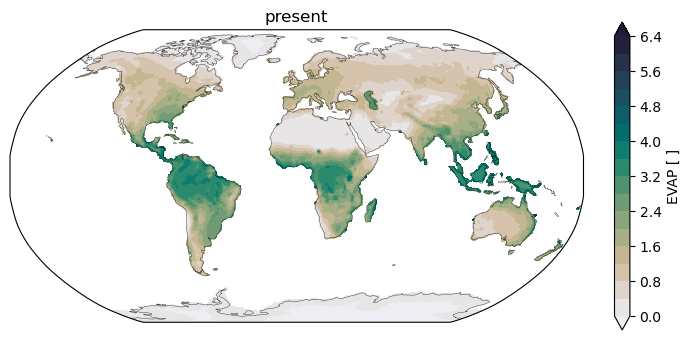

In [213]:
plot_scheff('evap', 'present')

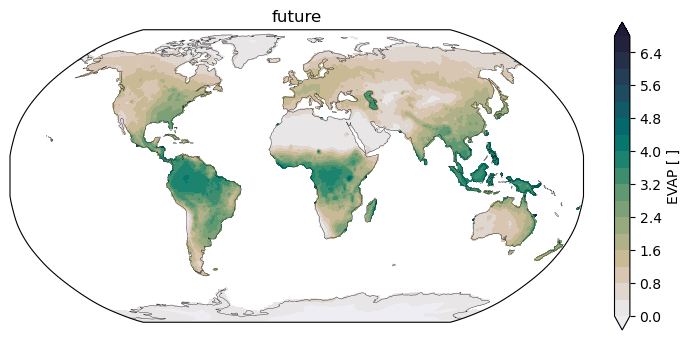

In [214]:
plot_scheff('evap', 'future')

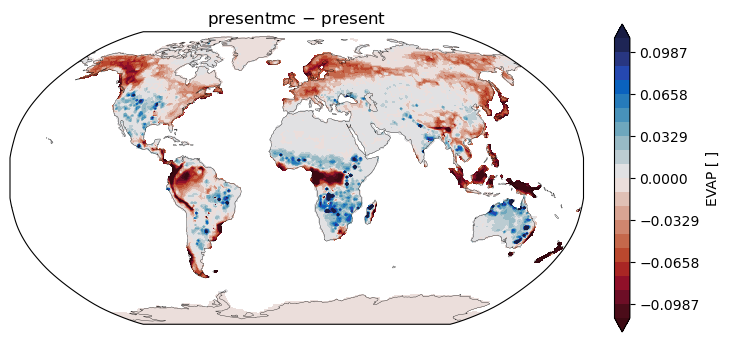

In [215]:
plot_scheff('evap', 'presentmc', 'present')

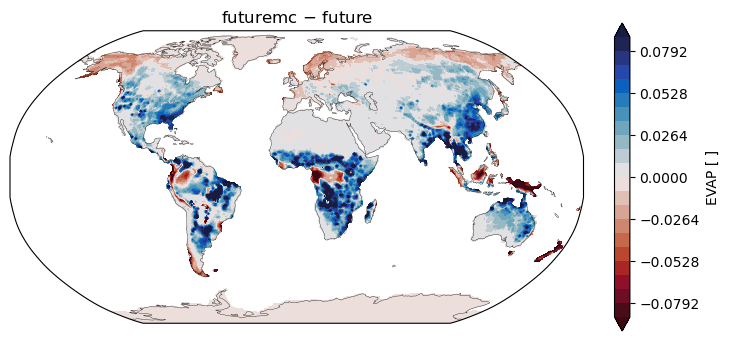

In [216]:
plot_scheff('evap', 'futuremc', 'future')

## $P-E$

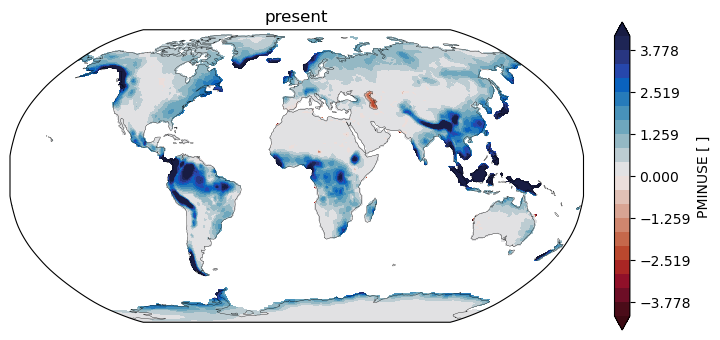

In [217]:
plot_scheff('pminuse', 'present')

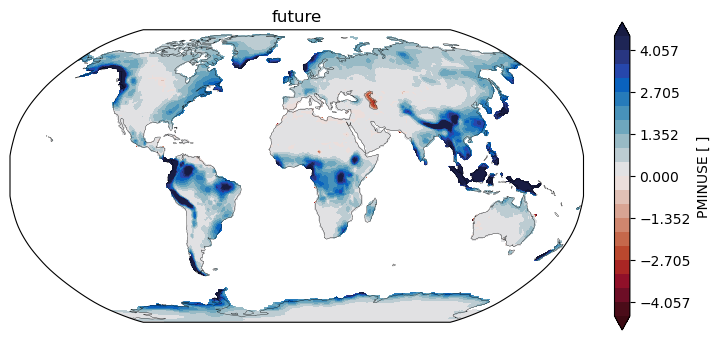

In [218]:
plot_scheff('pminuse', 'future')

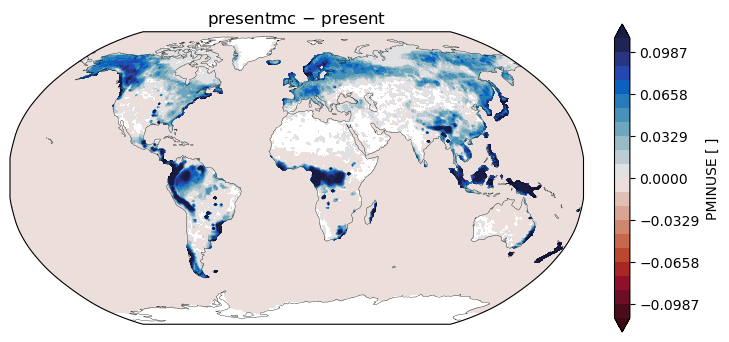

In [219]:
plot_scheff('pminuse', 'presentmc', 'present')

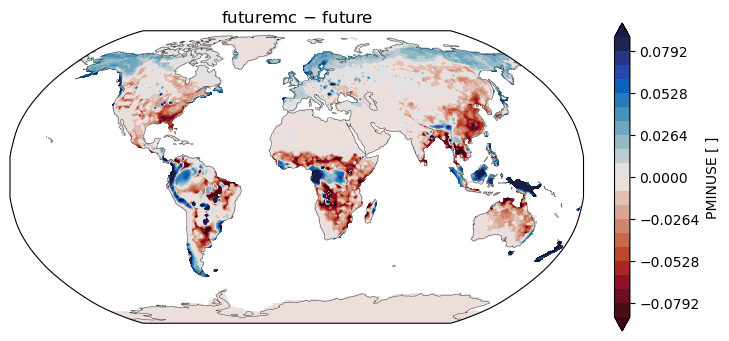

In [220]:
plot_scheff('pminuse', 'futuremc', 'future')

## Soil liquid saturation 2m

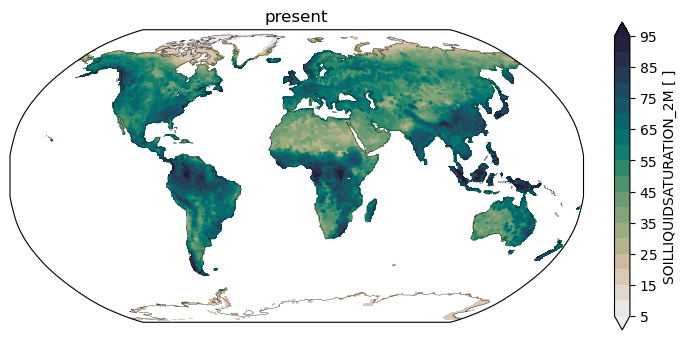

In [221]:
plot_scheff('soilliquidsaturation_2m', 'present')

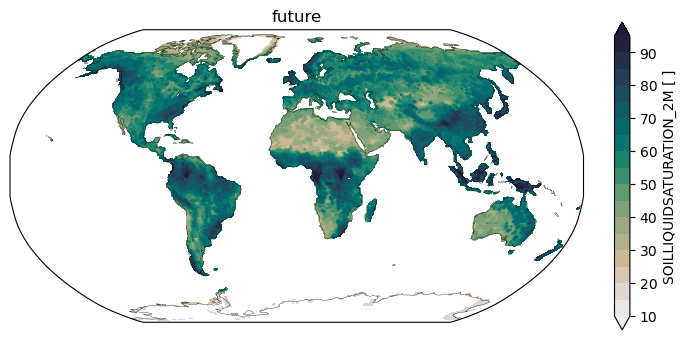

In [222]:
plot_scheff('soilliquidsaturation_2m', 'future')

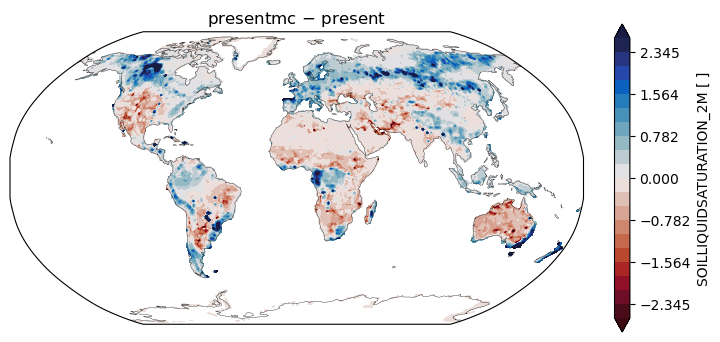

In [223]:
plot_scheff('soilliquidsaturation_2m', 'presentmc', 'present')

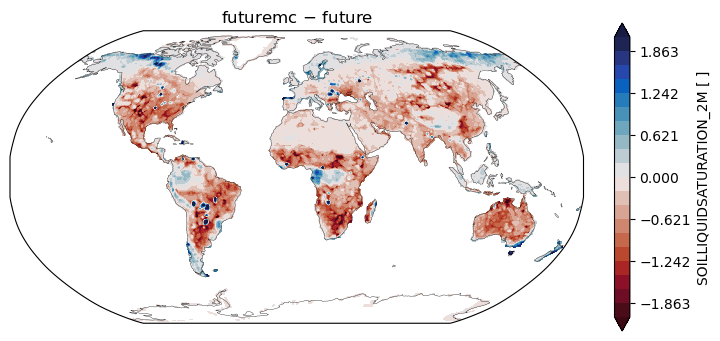

In [224]:
plot_scheff('soilliquidsaturation_2m', 'futuremc', 'future')

## Available energy

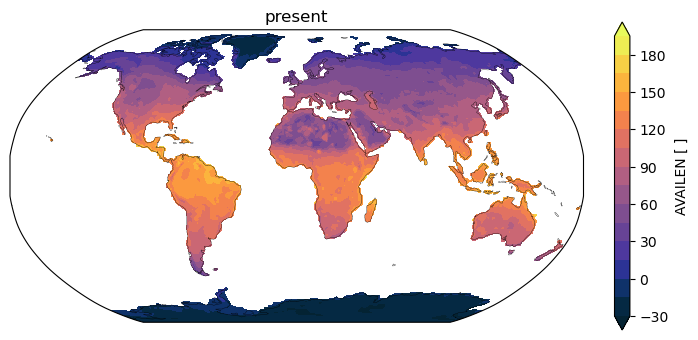

In [225]:
plot_scheff('availen', 'present')

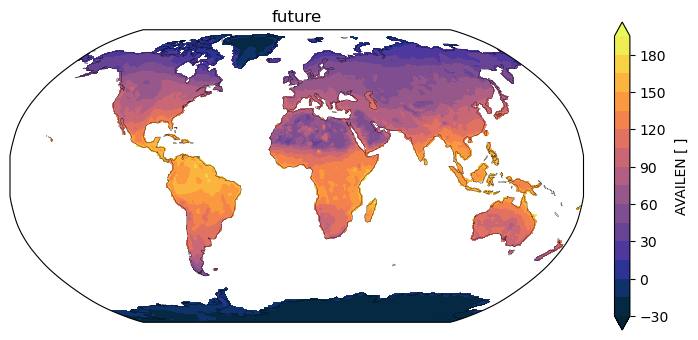

In [226]:
plot_scheff('availen', 'future')

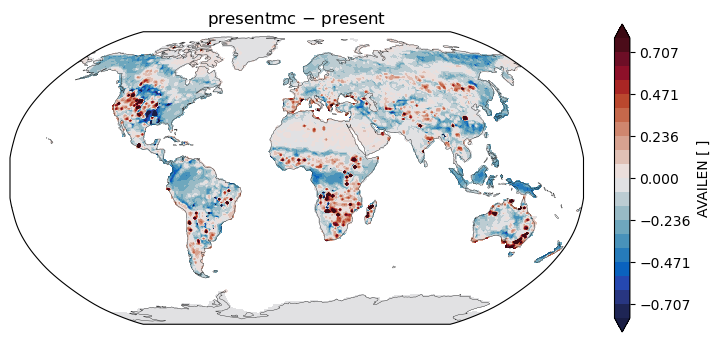

In [227]:
plot_scheff('availen', 'presentmc', 'present')

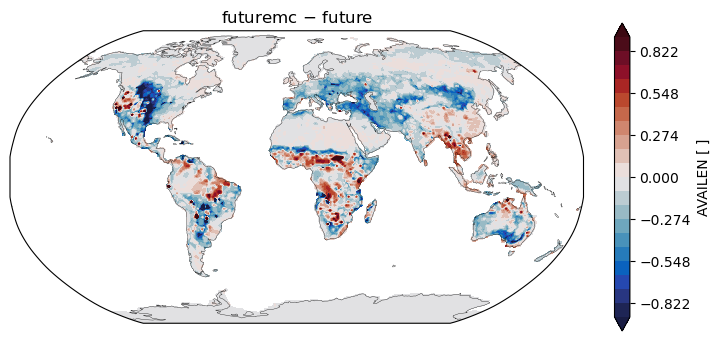

In [228]:
plot_scheff('availen', 'futuremc', 'future')

# CESM2 Constant VPD
Create maps of the same variables as Scheff et al. (2022) so that I can compare the response of fixing VPD

* PRECT = precip
* QRUNOFF = runoff
* QFLX_EVAP_TOT = evap ?

In [ ]:
case = {
    'cst':'minCnstVPDforPhoto_PI_SOM',
    'ctl':'COUP0000_PI_SOM'
}

path = {
    'cst': '/glade/scratch/bbuchovecky/archive/minCnstVPDforPhoto_PI_SOM/',
    'ctl': '/glade/scratch/bbuchovecky/archive/COUP0000_PI_SOM/'
}

with open('/glade/u/home/bbuchovecky/cesm_analysis_dicts/cesm2_masks.pkl', 'rb') as handle:
    masks = pkl.load(handle)

scomp = {
    'atm': 'cam',
    'lnd': 'clm2'
}

variable = {
    'atm':{
        # 'trefht',   # near-surface air temperature [degC]
        # 'prect',  # total precipitation rate [mm/day]
        # 'fsns',   # net solar flux at surface, +down [W/m2]
        # 'fsds',   # downwelling solar flux at surface, +down [W/m2]
        # 'fsus',   # upwelling solar flux at surface, +up [W/m2]
        # 'flns',   # net longwave flux at surface, +down [W/m2]
        # 'flds',   # downwelling longwave flux at surface, +down [W/m2]
        # 'flus',   # upwelling longwave flux at surface, +up [W/m2]
        # 'lhflx',  # latent heat flux at surface, +up [W/m2]
        # 'et',     # evapotranspiration flux at surface [mm/day]
        # 'shflx',  # sensible heat flux at surface, +up [W/m2]
        # 'nrad',   # net radiation at surface, +down [W/m2]
        # 'stor'    # heat uptake/storage of surface, +up [W/m2]
    },
    'lnd':{
        # 'gssunln',     # sunlit leaf stomatal conductance at local noon [umol/m2/s]
        # 'fctr',        # canopy transpiration [W/m2]
        # 'qvegt',       # canopy transpiration [mm/m2]
        # 'btran2',      # root zone soil wetness factor [1]
        # 'btranmn',     # daily minimum of transpiration beta factor [1]
        # 'tlai',        # total projected leaf area index [m2/m2]
        # 'gpp',         # gross primary production [gC/m2/s]
        # 'tsa',         # 2m air temperature [K]
        # 'tranlai',     # canopy transpiration per LAI (FCTR/TLAI)
        # 'h2osoi',      # volumetric soil water [mm3/mm3]
        'soilliq',     # soil liquid water [kg/m2]
        # 'totsoilliq',  # vertically summed soil liquid water [kg/m2	]
        # 'npp_nuptake', # total C used by N uptake in FUN [gC/m2/s]
        # 'nuptake',     # total N uptake of FUN [gN/m2/s]
    }
}

calc_variable = ['prect']

unit = {
    'gssunln':'[$\mu$mol H$_2$O m$^{-2}$ s$^{-1}$]',
    'fctr':'[W m$^{-2}$]',
    'btran2':'[1]',
    'btranmn':'[1]',
    'tlai':'[m$^2$ m$^{-2}$]',
    'gpp':'[gC m$^{-2}$ s$^{-1}$]',
    'tsa':'[K]',
    'tranlai':'[(W m$^{-2}$) (m$^2$ m$^{-2}$)$^{-1}$]'
}

subplot_kws = {'projection': ccrs.Robinson()}
cbar_kwargs = {'orientation':'vertical', 'fraction':0.025}

tslice = slice('0049-01','0099-12')